In [36]:
# Inspired from https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-ga-customer-revenue/notebook
import gc
import re
import json
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [37]:
IN_TRAIN = 'in/train-flat.csv'
IN_TEST = 'in/test-flat.csv'

OUT_TRAIN = 'in/train-pruned.csv'
OUT_TEST = 'in/test-pruned.csv'

In [38]:
%%time
train_df = pd.read_csv(IN_TRAIN, dtype={'fullVisitorId': 'str'}, low_memory=False)
train_df, _ = train_test_split(train_df, train_size=10000, shuffle=True, random_state=42)

CPU times: user 17 s, sys: 1.2 s, total: 18.2 s
Wall time: 20 s


In [39]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
225409,Organic Search,20161208,3485648249216919396,3485648249216919396_1481220145,Not Socially Engaged,1481220145,1,1481220145,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
553006,Organic Search,20170323,7608880037066407324,7608880037066407324_1490289598,Not Socially Engaged,1490289598,1,1490289598,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
868331,Referral,20170512,5124287655575518739,5124287655575518739_1494638891,Not Socially Engaged,1494638891,1,1494638891,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/,mall.googleplex.com
782366,Referral,20161120,0111261597665013586,0111261597665013586_1479703276,Not Socially Engaged,1479703276,2,1479703276,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
72255,Social,20160917,4801065279617993658,4801065279617993658_1474123523,Not Socially Engaged,1474123523,1,1474123523,Safari,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/es/,youtube.com


In [40]:
%%time
test_df = pd.read_csv(IN_TEST, dtype={'fullVisitorId': 'str'}, low_memory=False).head(n=1000)

CPU times: user 12 s, sys: 716 ms, total: 12.8 s
Wall time: 13.4 s


In [41]:
test_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),True,(not provided),organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google


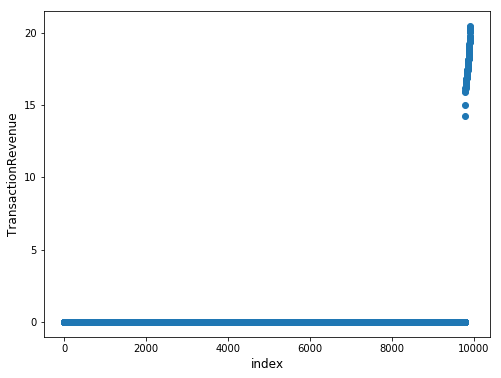

In [42]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [43]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  117  and ratio is :  0.0117
Number of unique customers with non-zero revenue :  117 and the ratio is :  0.01180268334510239


In [44]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
225409,Organic Search,20161208,3485648249216919396,3485648249216919396_1481220145,Not Socially Engaged,1481220145,1,1481220145,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
553006,Organic Search,20170323,7608880037066407324,7608880037066407324_1490289598,Not Socially Engaged,1490289598,1,1490289598,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
868331,Referral,20170512,5124287655575518739,5124287655575518739_1494638891,Not Socially Engaged,1494638891,1,1494638891,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/,mall.googleplex.com
782366,Referral,20161120,0111261597665013586,0111261597665013586_1479703276,Not Socially Engaged,1479703276,2,1479703276,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
72255,Social,20160917,4801065279617993658,4801065279617993658_1474123523,Not Socially Engaged,1474123523,1,1474123523,Safari,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/yt/about/es/,youtube.com


In [45]:
# remove cols which are not available in demo dataset
# TODO
# cols_not_available_in_demo_dataset = 
def remove_not_av_cols(df):
    not_av_series = df.iloc[0] == 'not available in demo dataset'
    not_av_cols = not_av_series[not_av_series == True].keys()
    new_df = df.drop(not_av_cols, axis=1)
    not_av_series = df.iloc[0] == '(not provided)'
    not_av_cols = not_av_series[not_av_series == True].keys()
    new_df = new_df.drop(not_av_cols, axis=1)
#     not_av_series = df.loc[10] == 'not available in demo dataset'
#     not_av_cols = not_av_series[not_av_series == True].keys()
#     new_df = new_df.drop(not_av_cols, axis=1)
    return new_df

train_df_pruned = remove_not_av_cols(train_df)
train_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.referralPath,trafficSource.source
225409,Organic Search,20161208,3485648249216919396,3485648249216919396_1481220145,Not Socially Engaged,1481220145,1,1481220145,Chrome,mobile,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,organic,NaN,google
553006,Organic Search,20170323,7608880037066407324,7608880037066407324_1490289598,Not Socially Engaged,1490289598,1,1490289598,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,organic,NaN,google
868331,Referral,20170512,5124287655575518739,5124287655575518739_1494638891,Not Socially Engaged,1494638891,1,1494638891,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/,mall.googleplex.com
782366,Referral,20161120,0111261597665013586,0111261597665013586_1479703276,Not Socially Engaged,1479703276,2,1479703276,Chrome,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,True,referral,/,mall.googleplex.com
72255,Social,20160917,4801065279617993658,4801065279617993658_1474123523,Not Socially Engaged,1474123523,1,1474123523,Safari,desktop,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/yt/about/es/,youtube.com


In [48]:
test_df_pruned = remove_not_av_cols(test_df)
test_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,desktop,...,NaN,NaN,NaN,NaN,NaN,(not set),True,organic,NaN,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,desktop,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,organic,NaN,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,desktop,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,organic,NaN,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,mobile,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,organic,NaN,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,desktop,...,NaN,NaN,NaN,NaN,NaN,(not set),NaN,organic,NaN,google


In [49]:
cols_to_discard = ['trafficSource.adContent',
                  'trafficSource.adwordsClickInfo.adNetworkType',
                  'trafficSource.adwordsClickInfo.gclId',
                  'trafficSource.adwordsClickInfo.page',
                  'trafficSource.adwordsClickInfo.slot',
                  'trafficSource.campaign', 'trafficSource.campaignCode', 'trafficSource.referralPath']

train_df_pruned = train_df_pruned.drop(cols_to_discard, axis=1)
train_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.source
225409,Organic Search,20161208,3485648249216919396,3485648249216919396_1481220145,Not Socially Engaged,1481220145,1,1481220145,Chrome,mobile,...,NaN,8,1.0,7.0,NaN,1,NaN,NaN,organic,google
553006,Organic Search,20170323,7608880037066407324,7608880037066407324_1490289598,Not Socially Engaged,1490289598,1,1490289598,Chrome,desktop,...,1.0,1,1.0,1.0,NaN,1,NaN,NaN,organic,google
868331,Referral,20170512,5124287655575518739,5124287655575518739_1494638891,Not Socially Engaged,1494638891,1,1494638891,Chrome,desktop,...,NaN,17,1.0,15.0,NaN,1,NaN,NaN,referral,mall.googleplex.com
782366,Referral,20161120,0111261597665013586,0111261597665013586_1479703276,Not Socially Engaged,1479703276,2,1479703276,Chrome,desktop,...,NaN,35,NaN,35.0,18330000.0,1,NaN,True,referral,mall.googleplex.com
72255,Social,20160917,4801065279617993658,4801065279617993658_1474123523,Not Socially Engaged,1474123523,1,1474123523,Safari,desktop,...,1.0,1,1.0,1.0,NaN,1,NaN,NaN,referral,youtube.com


In [50]:
cols_to_discard_test = [col for col in cols_to_discard if col not in ['trafficSource.campaignCode']]

test_df_pruned = test_df_pruned.drop(cols_to_discard_test, axis=1)
test_df_pruned.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,...,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.visits,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,trafficSource.medium,trafficSource.source
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,desktop,...,Southeast Asia,NaN,4,NaN,4.0,1,NaN,True,organic,google
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,desktop,...,Southern Europe,NaN,5,1.0,5.0,1,NaN,NaN,organic,google
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,desktop,...,Western Europe,NaN,7,1.0,7.0,1,NaN,NaN,organic,google
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,mobile,...,Northern America,NaN,8,1.0,4.0,1,NaN,NaN,organic,google
4,Organic Search,20171016,2314544520795440038,2314544520795440038_1508217442,Not Socially Engaged,1508217442,1,1508217442,Safari,desktop,...,Northern America,NaN,9,1.0,4.0,1,NaN,NaN,organic,google


In [51]:
%%time
train_df_pruned.to_csv(OUT_TRAIN, index=False)
test_df_pruned.to_csv(OUT_TEST, index=False)

CPU times: user 272 ms, sys: 4 ms, total: 276 ms
Wall time: 280 ms
